In [186]:
import sklearn
import numpy as np
from tensorflow import keras
from explainer.metrics import draw_network
from pgmpy.utils import get_example_model
import wandb
import copy
from ucimlrepo import fetch_ucirepo
from lime.lime_tabular import LimeTabularExplainer
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import re

In [187]:
wandb.login()

True

#### Data

In [189]:
national_poll_on_healthy_aging_npha = fetch_ucirepo(id = 936) 

X = national_poll_on_healthy_aging_npha.data.features.to_numpy()
y = national_poll_on_healthy_aging_npha.data.targets.to_numpy()

feature_names = list(national_poll_on_healthy_aging_npha.data.features.columns)
class_name = national_poll_on_healthy_aging_npha.data.targets.columns[0]

#### Model

In [190]:
model = RandomForestClassifier(random_state = 0)
model.fit(X, y.squeeze())

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Feature Attribution

In [698]:
class Explainer:
    
    def __init__(self, model, X, feature_names, target_name, n_samples = 100, rep_prob = 0.5):
        
        self.X = X
        
        self.x_cols = feature_names
        self.y_col = target_name
        
        self.model = model
        
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        self.associations = None
        self.data = None
        
        self.dag = None
        self.pdag = None
        
    def data_generation(self, x):
        
        y = self.model.predict(x.reshape(1, -1)).squeeze(0)
        
        random_indices = np.random.randint(len(self.X), size = self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X = np.where(replace_mask, x, samples_X_base)
                
        samples_Y = self.model.predict(samples_X)
                
        samples_Y_bool = samples_Y != y
        
        samples_X_bool = samples_X != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns = self.x_cols)
        self.data[self.y_col] = samples_Y_int

    def fp_growth(self, min_support, min_threshold):
        
        data = self.data.astype(bool)
        
        patterns = fpgrowth(data, min_support = min_support, use_colnames = True)
        
        self.associations = association_rules(patterns, metric = "confidence", min_threshold = min_threshold)

    def statistical_relevance(self):
        
        associations = self.associations[self.associations['consequents'] == frozenset({self.y_col})]
        
        associations = associations.sort_values(by = 'confidence', ascending = False).reset_index(drop = True)
        
        redundant = set()
        
        for i in range(len(associations)):
            
            if i in redundant:
                continue
            
            super_ant = associations.loc[i, 'antecedents']
            super_conf = associations.loc[i, 'confidence']
            
            for j in range(len(associations)):
                
                if i == j or j in redundant:
                    continue
                
                sub_ant = associations.loc[j, 'antecedents']
                sub_conf = associations.loc[j, 'confidence']
                
                if sub_ant.issubset(super_ant) and sub_ant != super_ant and sub_conf >= super_conf:
                    
                    redundant.add(i)
                    break
        
        associations = associations.drop(index = list(redundant)).reset_index(drop = True)
        
        self.associations = associations[['antecedents', 'consequents', 'support', 'confidence']]

    def structures(self):
        
        nodes = set()
        edges = set()
        
        for i in range(len(self.associations)):
            
            ant_nodes = list(self.associations.loc[i, 'antecedents'])
            ant_edges = list(itertools.combinations(ant_nodes + [self.y_col], 2))
            
            nodes.update(ant_nodes)
            edges.update(ant_edges)
        
        self.pdag = PDAG(undirected_ebunch = list(edges))
        
        forbidden_edges = [(self.y_col, node) for node in nodes]
        
        no_child_constraint = ExpertKnowledge(forbidden_edges = forbidden_edges)

        est = HillClimbSearch(data = self.data[list(nodes) + [self.y_col]])

        self.dag = est.estimate(scoring_method = "bic-d", expert_knowledge = no_child_constraint)
        
    def explain(self, x, min_support, min_threshold):
        
        self.data_generation(x)
        self.fp_growth(min_support, min_threshold)
        self.statistical_relevance()
        self.structures()

In [705]:
explainer = Explainer(model, X, feature_names, class_name, n_samples = 5000, rep_prob = 0.1)

features = explainer.explain(X[34], 0.1, 0.5)

print(len(explainer.data[explainer.data[explainer.y_col] == 1]))

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Physical_Health': 'N', 'Dental_Health': 'N', 'Trouble_Sleeping': 'N', 'Uknown_Keeps_Patient_from_Sleeping': 'N', 'Bathroom_Needs_Keeps_Patient_from_Sleeping': 'N', 'Number_of_Doctors_Visited': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Physical_Health': 'N', 'Dental_Health': 'N', 'Trouble_Sleeping': 'N', 'Uknown_Keeps_Patient_from_Sleeping': 'N', 'Bathroom_Needs_Keeps_Patient_from_Sleeping': 'N', 'Number_of_Doctors_Visited': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Physical_Health': 'N', 'Dental_Health': 'N', 'Trouble_Sleeping': 'N', 'Uknown_Keeps_Patient_from_Sleeping': 'N', 'Bathroom_Needs_Keeps_Patient_from_Sleeping': 'N', 'Number_of_Doctors_Visited': 'N'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

2133


In [706]:
explainer.associations

,antecedents,consequents,support,confidence
0,"(Physical_Health, Uknown_Keeps_Patient_from_Sl...",(Number_of_Doctors_Visited),0.1168,0.532847
1,"(Trouble_Sleeping, Physical_Health, Dental_Hea...",(Number_of_Doctors_Visited),0.1112,0.505455
2,"(Physical_Health, Bathroom_Needs_Keeps_Patient...",(Number_of_Doctors_Visited),0.1002,0.504024


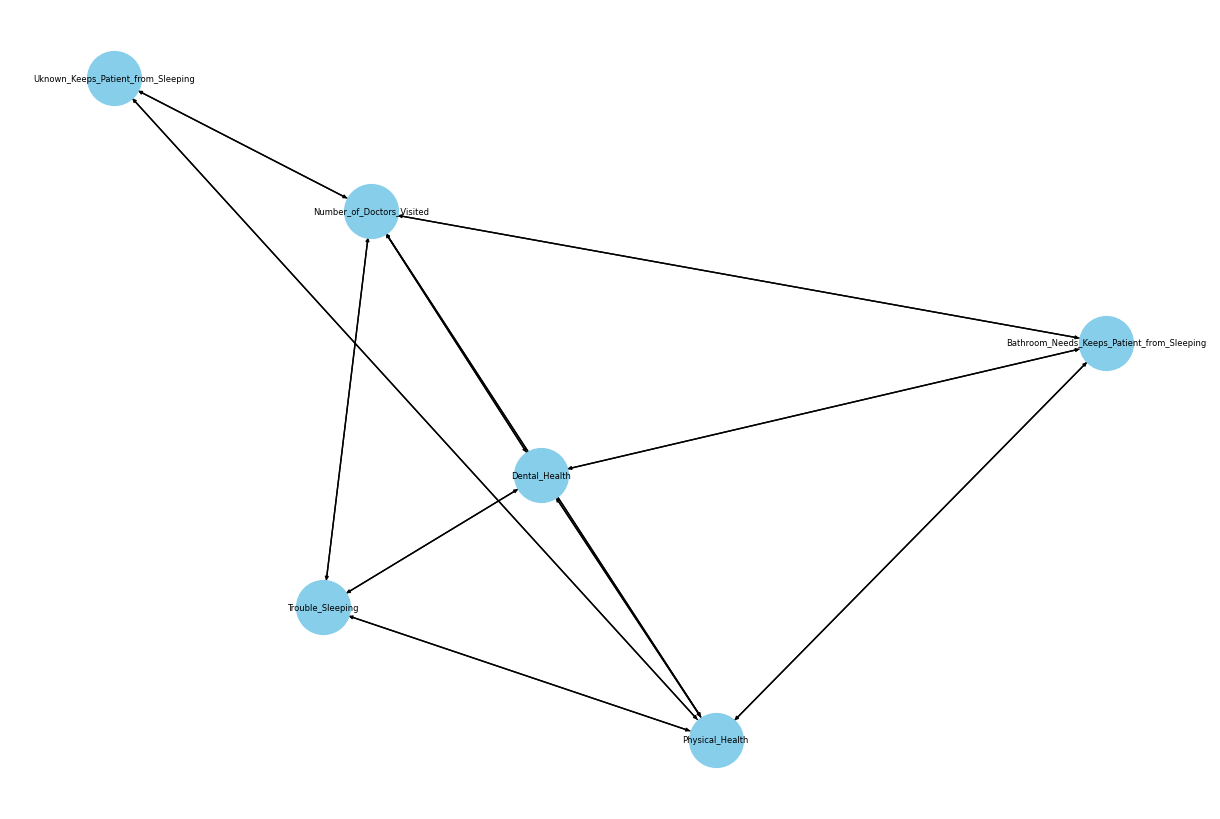

In [707]:
draw_network(explainer.pdag)

#### Feature Attribution

In [553]:
def lime_features(instance, training_data, model, feature_names, class_name):

    explainer = LimeTabularExplainer(
        training_data = training_data,
        feature_names = feature_names,
        class_names = class_name,
        mode = 'classification'
    )

    exp = explainer.explain_instance(instance, model.predict_proba, num_features = len(feature_names))

    important_features = exp.as_list()
    sorted_features = [re.sub(r"[\d+\-*/<>.=() ]", "", feature) for feature, weight in sorted(important_features, key = lambda x: abs(x[1]), reverse = True)]

    return sorted_features

In [554]:
def explainer_features(instance, training_data, model, feature_names, class_name):
    
    explainer = Explainer(model, training_data, feature_names, class_name, n_samples = 2000, rep_prob = 0.1)

    features = explainer.explain(instance)

    return list(features)